 # Inference using the astrocyte data


 This tutorial demonstrates how to train a GET model to predict expression in ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Finetune from a pretrained expression prediction GET model

 3. Perform various analysis using `gcell` package



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


 ## Finetune



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial.yaml`

In [26]:
if not Path('./checkpoint-best.pth').exists():
    s3_checkpoint_url = "s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth"
    ! aws s3 cp $s3_checkpoint_url ./checkpoint-best.pth --no-sign-request

Download the astrocyte data

In [2]:
if not Path('astrocyte.zarr').exists():
    ! wget https://zenodo.org/records/14614947/files/astrocyte.zarr.tar?download=1
    ! mv astrocyte.zarr.tar?download=1 astrocyte.zarr.tar
    ! tar -xvf astrocyte.zarr.tar

> Note: In the paper, we mainly used binary ATAC signal trained model for motif interpretation analysis. As it's hard to say whether there are mutual causal relationship between transcription and accessibility. If accessibility is added to the model, potentially it will absorb some TF's effect to itself, thereby making the interpretation more difficult. However, if the goal is to represent the cell states as precisely as possible and use the model for other downstream tasks (e.g. enhancer target prediction), adding the accessibility signal is probably better.

In [78]:
celltype_for_modeling = [
    'astrocyte']
cfg = load_config('finetune_tutorial') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.project_name = 'astrocyte'
cfg.run.run_name = 'astrocyte'
cfg.dataset.quantitative_atac = True # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = "./astrocyte.zarr" # set the path to the data zarr file we just processed
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to finetune
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_celltypes = 'astrocyte' # set the celltypes you want to leave out
cfg.machine.num_devices=1 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=4 # batch size for training; check `nvidia-smi` to see the available GPU memory
# cfg.machine.output_dir = "./output/"
print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /home/xf2217/output/astrocyte/astrocyte
training for 100 epochs


In [79]:
# export the config to a yaml file
from get_model.config.config import export_config, load_config_from_yaml

export_config(cfg, "exported_training_config.yaml")

In [80]:
# load the config from the yaml file
cfg = load_config_from_yaml("exported_training_config.yaml")
cfg.stage='validate'

In [81]:
print(f"Default checkpoint path is at: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}/checkpoints/best.ckpt")
print("The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training")

Default checkpoint path is at: /home/xf2217/output/astrocyte/astrocyte/checkpoints/best.ckpt
The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training


100%|██████████| 1/1 [00:00<00:00, 51.85it/s]
/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Leave out chromosomes: ['chr11']
Input chromosomes: ['chr11']
Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model
PearsonRResult(statistic=0.9302050277731757, pvalue=0.0)


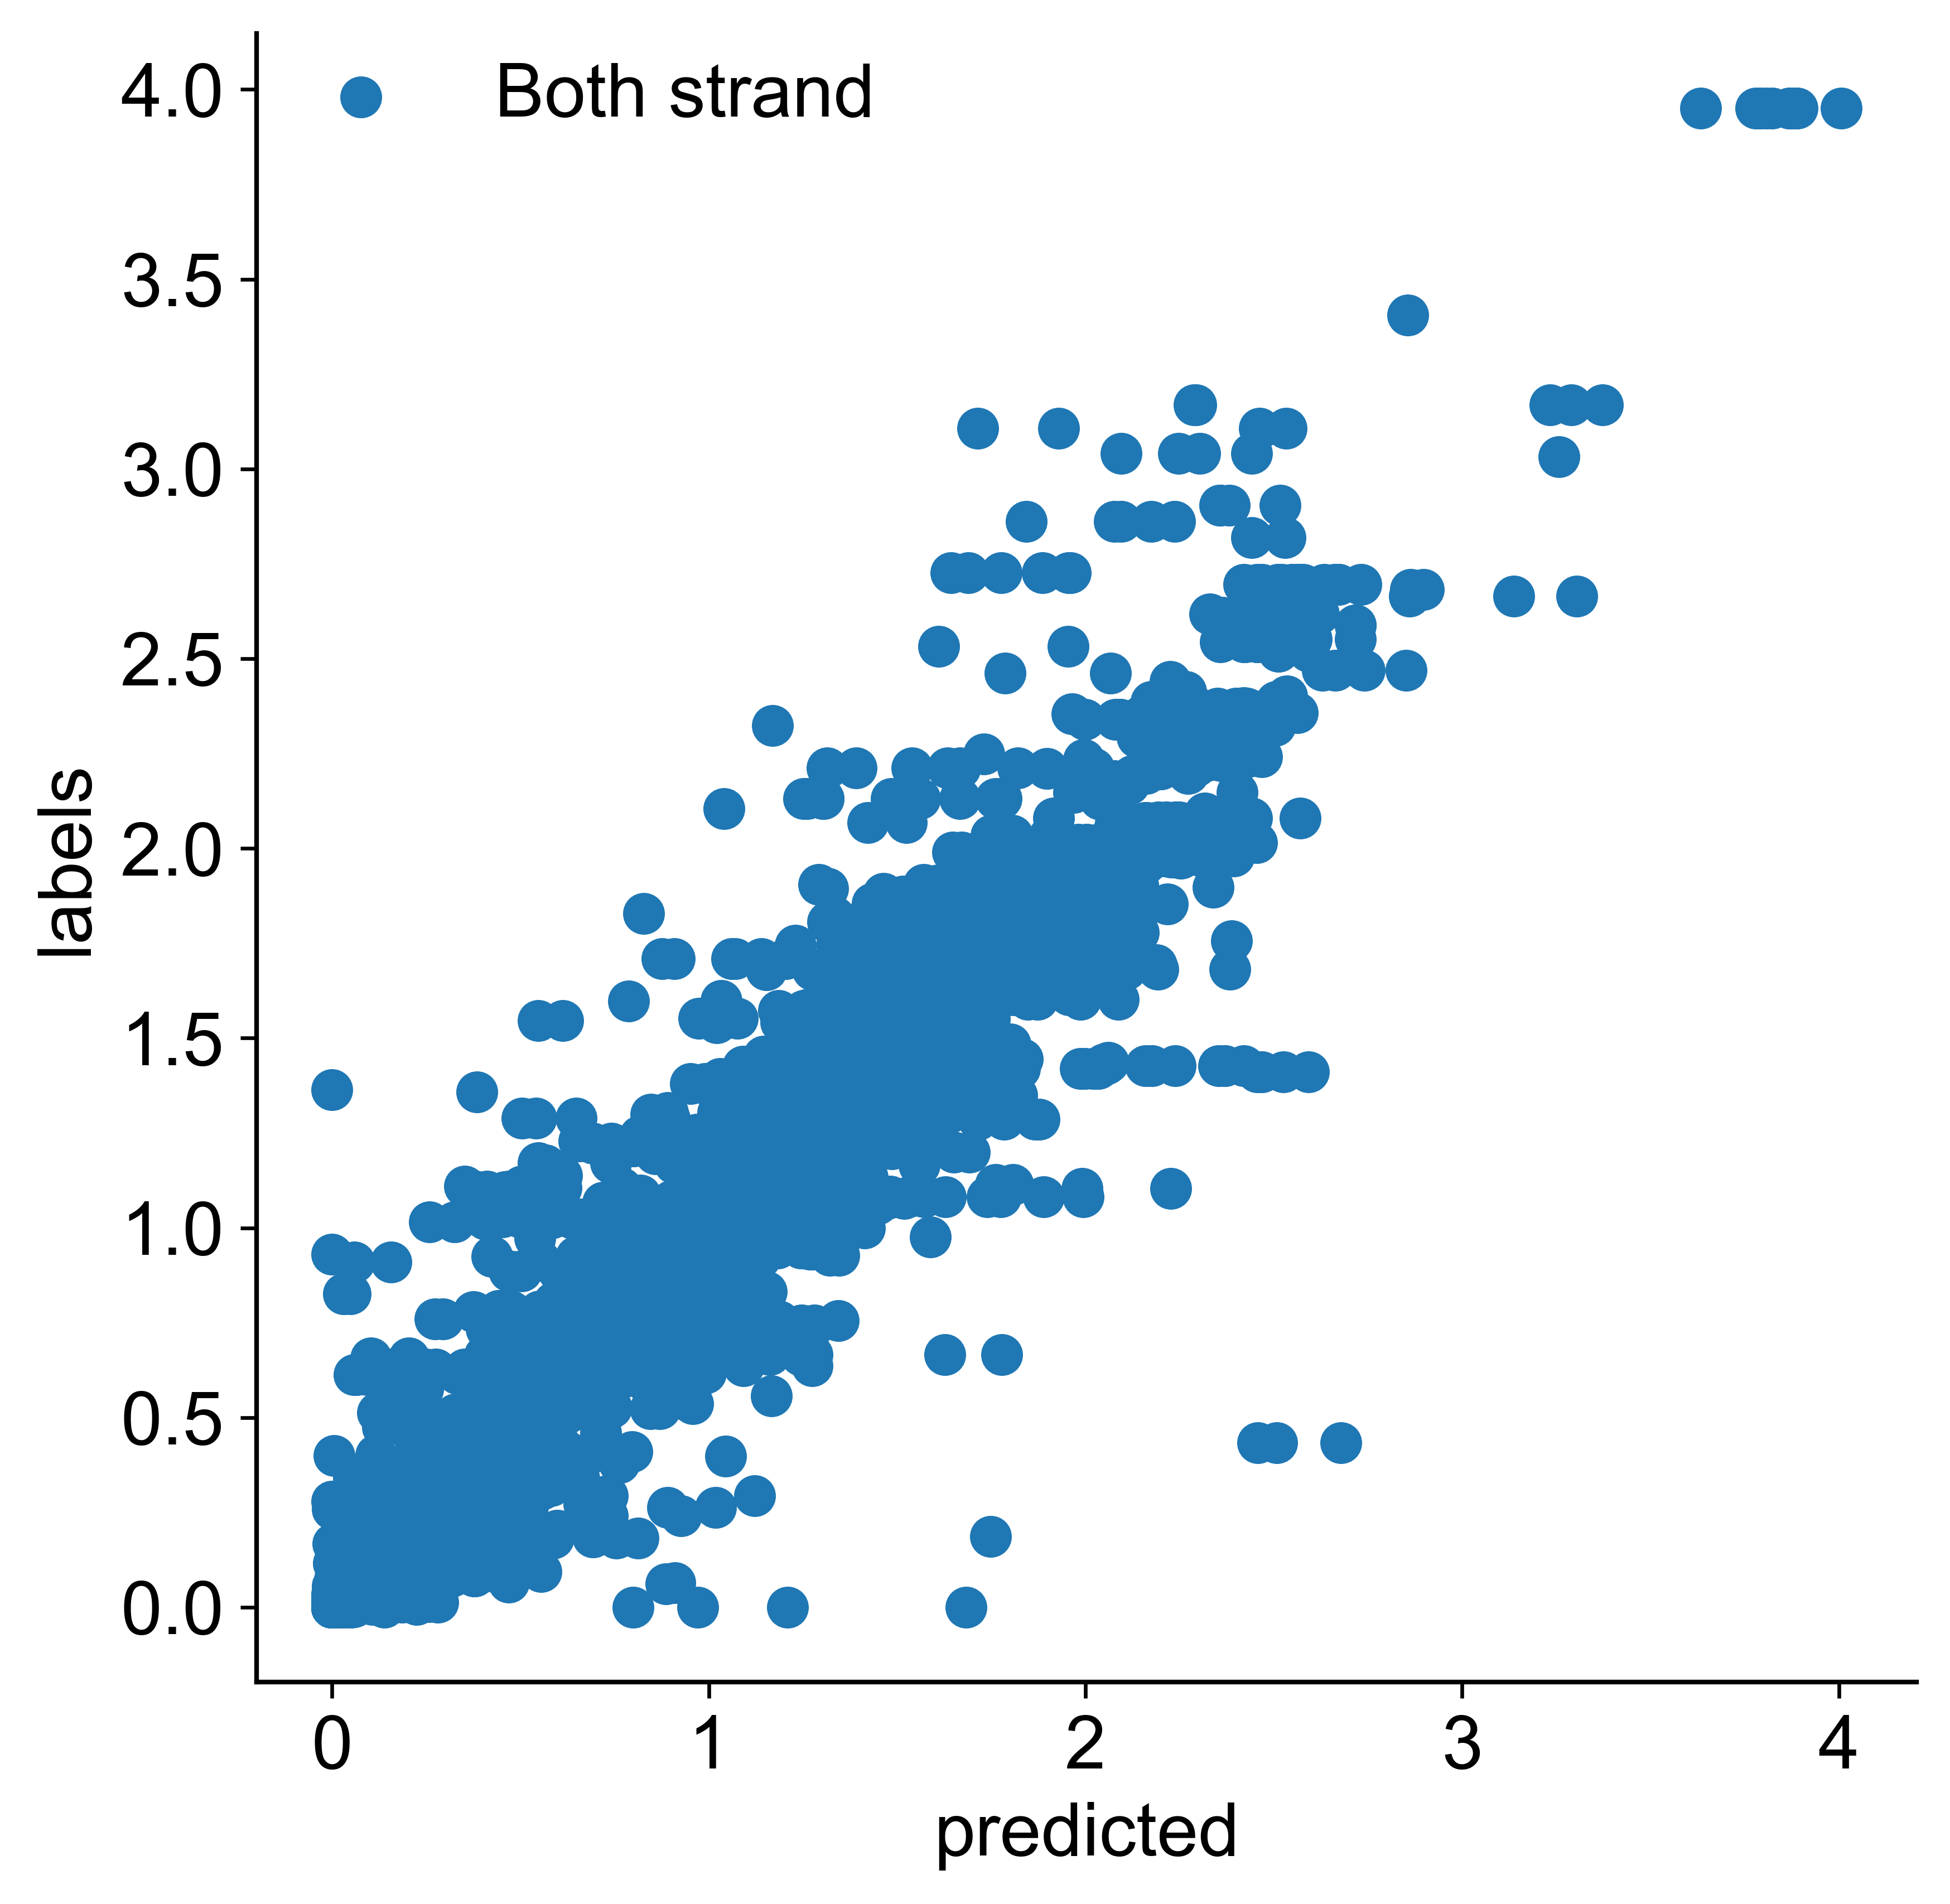

In [82]:
from get_model.dataset.zarr_dataset import RegionMotifDataset, InferenceRegionMotifDataset
import torch
import logging
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from hydra.utils import instantiate

from get_model.dataset.zarr_dataset import RegionMotifDataset
from get_model.config.config import load_config_from_yaml
from get_model.utils import load_checkpoint, extract_state_dict, rename_state_dict, load_state_dict

def get_model(cfg):
    model = instantiate(cfg.model)

    # Load main model checkpoint
    if cfg.finetune.checkpoint is not None:
        checkpoint_model = load_checkpoint(
            cfg.finetune.checkpoint, model_key=cfg.finetune.model_key
        )
        checkpoint_model = extract_state_dict(checkpoint_model)
        checkpoint_model = rename_state_dict(
            checkpoint_model, cfg.finetune.rename_config
        )
        load_state_dict(
            model, checkpoint_model, strict=cfg.finetune.strict
        )

    # Load additional checkpoints
    if len(cfg.finetune.additional_checkpoints) > 0:
        for checkpoint_config in cfg.finetune.additional_checkpoints:
            checkpoint_model = load_checkpoint(
                checkpoint_config.checkpoint, model_key=checkpoint_config.model_key
            )
            checkpoint_model = extract_state_dict(checkpoint_model)
            checkpoint_model = rename_state_dict(
                checkpoint_model, checkpoint_config.rename_config
            )
            load_state_dict(
                model, checkpoint_model, strict=checkpoint_config.strict
            )

    model.freeze_layers(
        patterns_to_freeze=cfg.finetune.patterns_to_freeze, invert_match=False
    )
    logging.debug("Model = %s" % str(model))
    return model


# load the config from the yaml file
cfg = load_config_from_yaml("exported_training_config.yaml")
cfg.stage='validate'

# Load dataset
dataset = RegionMotifDataset(
    **cfg.dataset,
    is_train=False,
)

# Create DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg.machine.batch_size,
    num_workers=cfg.machine.num_workers,
    drop_last=False,
    shuffle=False,
)

# Load model
model = get_model(cfg)
model.eval()

results = []
labels = []
with torch.no_grad():
    for batch in dataloader:
        tss_mask = batch['mask'].numpy()
        outputs = model(batch['region_motif']).numpy()[tss_mask>0]
        if len(outputs)>0:
            results.extend(outputs)
            labels.extend(batch['exp_label'].numpy()[tss_mask>0])
results = np.array(results)
labels = np.array(labels)
plt.figure()
plt.scatter(results, labels, label='Both strand')
plt.legend()
plt.xlabel('predicted')
plt.ylabel('labels')

print(pearsonr(results, labels))


In [109]:
from gcell.rna.gencode import Gencode
from get_model.dataset.zarr_dataset import InferenceRegionMotifDataset
gencode_obj = {'hg38': Gencode(assembly='hg38')}
infer_dataset = InferenceRegionMotifDataset(
    assembly='hg38',
    gencode_obj=gencode_obj,
    gene_list=['BCL6'],
    zarr_path='./astrocyte.zarr',
    celltypes='astrocyte',
    transform=None,
    quantitative_atac=True,
    sampling_step=100,
    num_region_per_sample=200,
    leave_out_celltypes='astrocyte',
    mask_ratio=0.0,
    is_train=False,
)


100%|██████████| 1/1 [00:00<00:00, 54.40it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr4_GL000008v2_random', 'chr5', 'chr6', 'chr7', 'chr7_KI270803v1_alt', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr22_KI270879v1_alt', 'chrX']


In [110]:
infer_dataset[0]['region_motif'][:, -1]

array([0.0819114 , 0.16101652, 0.6582522 , 0.33152243, 0.12161803,
       0.2709176 , 0.09240795, 0.13033535, 0.065726  , 0.47874907,
       0.32128924, 1.        , 0.31215376, 0.1907122 , 0.19408873,
       0.0913685 , 0.12356886, 0.16905656, 0.09344516, 0.1117439 ,
       0.08718819, 0.06462743, 0.05686672, 0.06900676, 0.1312943 ,
       0.07009541, 0.07657631, 0.1117439 , 0.06242279, 0.07009541,
       0.06682206, 0.09757189, 0.06352637, 0.09757189, 0.08508439,
       0.5033075 , 0.9437357 , 0.09757189, 0.11571781, 0.06462743,
       0.20736362, 0.4688508 , 0.4176573 , 0.460202  , 0.05909682,
       0.12259442, 0.2899107 , 0.16371144, 0.05686672, 0.17346607,
       0.06131667, 0.05909682, 0.4123334 , 0.09032681, 0.10470987,
       0.1293745 , 0.11670619, 0.07871743, 0.0913685 , 0.09654351,
       0.3433993 , 0.09654351, 0.14452341, 0.065726  , 0.19324681,
       0.36572182, 0.11074528, 0.12161803, 0.0913685 , 0.14171895,
       0.23518963, 0.26803917, 0.1407805 , 0.11769256, 0.08928

In [111]:
infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset,
    batch_size=cfg.machine.batch_size,
    num_workers=cfg.machine.num_workers,
    drop_last=False,
    shuffle=False,
)

In [112]:
batch['region_motif'].shape

torch.Size([1, 200, 283])

In [113]:
for batch in infer_dataloader:
    print(batch)
    outputs = model(batch['region_motif']).detach().numpy()
    print(outputs.shape)
    break

{'region_motif': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0384, 0.0000, 0.0819],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1610],
         [0.0000, 0.0000, 0.0000,  ..., 0.0787, 0.0000, 0.6583],
         ...,
         [0.1625, 0.0000, 0.0000,  ..., 0.0293, 0.0000, 0.2082],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0679],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0755]]]), 'mask': tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 1],
         [0, 1],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 1],
         [0, 0],
       

In [130]:
outputs1 = model(batch['region_motif']).detach().numpy()
perturb_data = batch['region_motif'].clone()
perturb_data[:, 98:103, :] = 0
outputs2 = model(perturb_data).detach().numpy()



In [147]:
perturb_coords = batch['peak_coord'][0, 98:103, :].sum(axis=1)/2
perturb_coords = perturb_coords.numpy()
chrom = batch['chromosome']

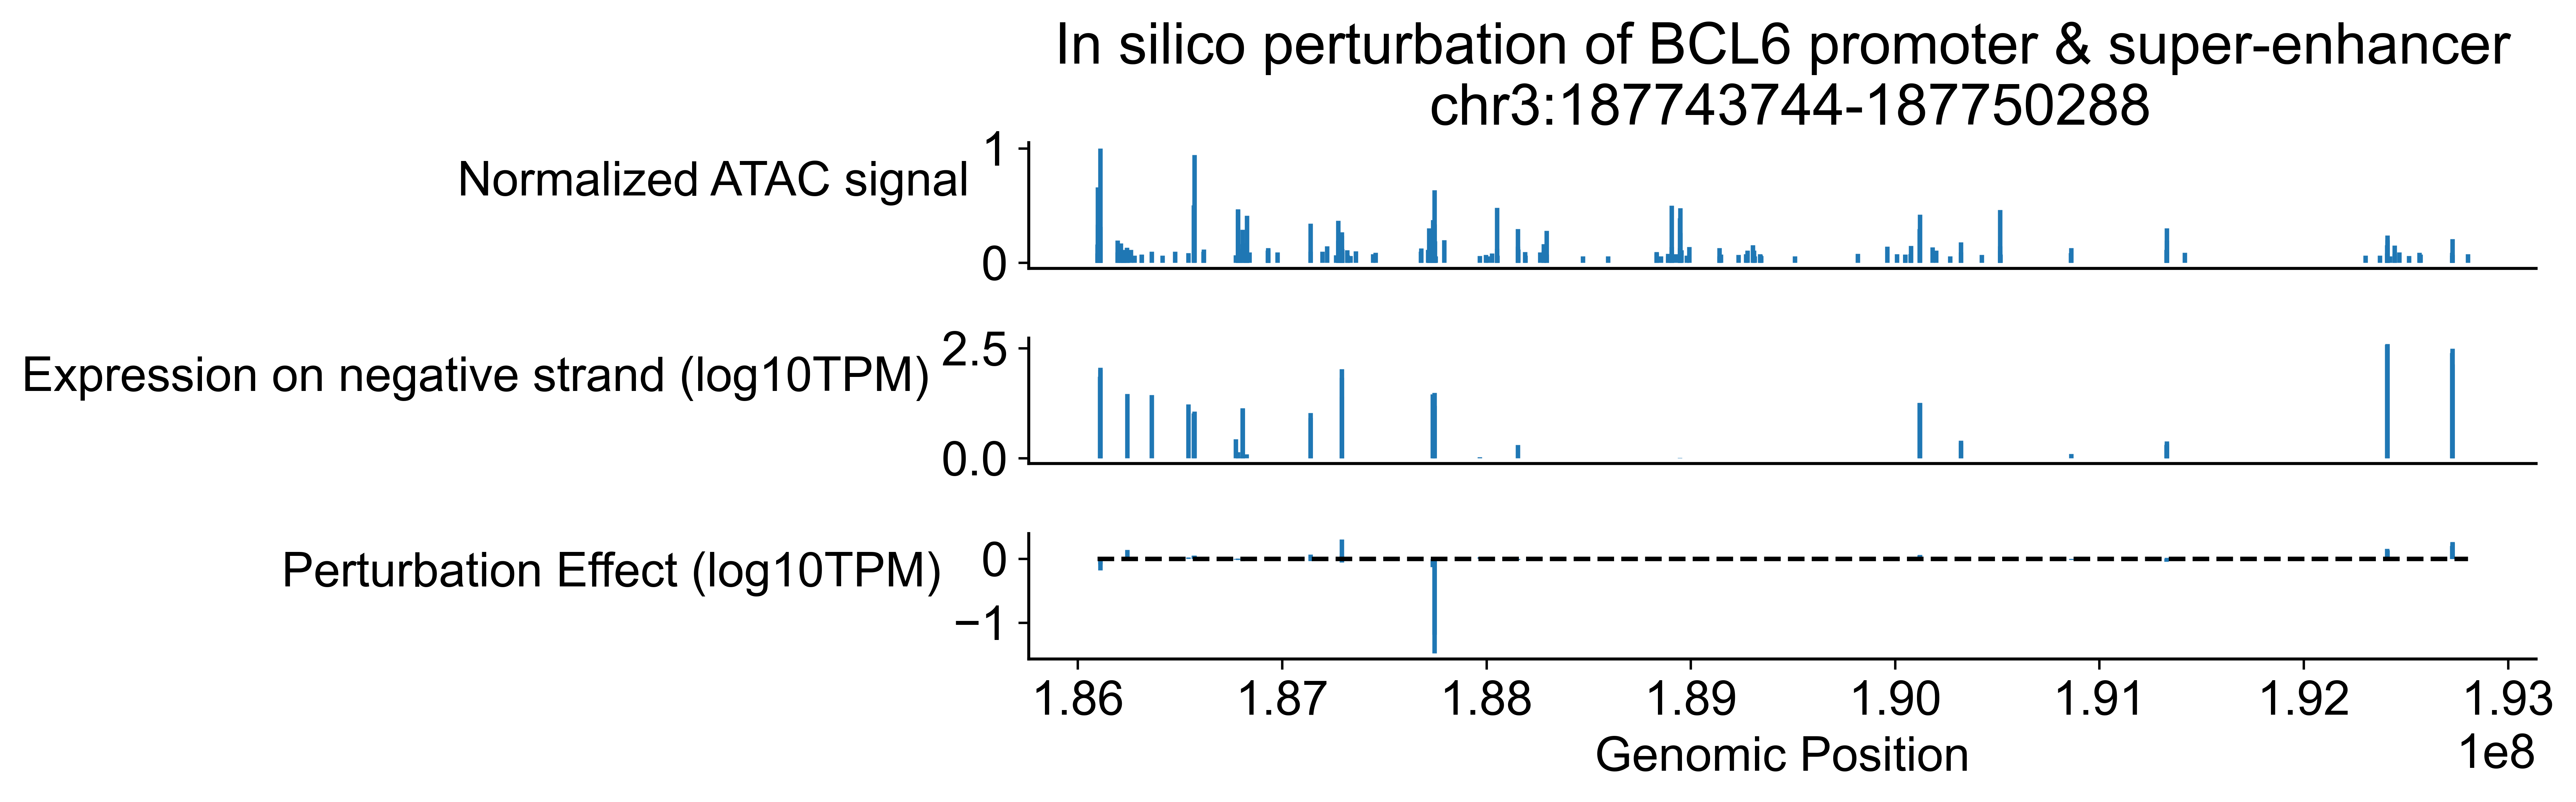

In [185]:
# Create a lollipop plot to visualize the difference between perturbed and original outputs
fig, ax = plt.subplots(3, 1, figsize=(12, 4))
x_coords = batch['peak_coord'][0].sum(axis=1).numpy()/2
y_values = outputs2[0, :, 1]-outputs1[0, :, 1]

# plot the atac signal
ax[0].stem(x_coords, batch['region_motif'][0, :, -1].numpy(), markerfmt='', linefmt='-', basefmt=' ')
# plot the original expression
ax[1].stem(x_coords, outputs1[0, :, 1], markerfmt='', linefmt='-', basefmt=' ')
# Plot the stems (lines)
ax[2].stem(x_coords, y_values, markerfmt='', linefmt='-', basefmt=' ')

# remove the x axis labels for the first two plots
ax[0].set_xticks([])
ax[1].set_xticks([])


# Customize the plot
ax[0].set_ylabel('Normalized ATAC signal', rotation=0, ha='right')
ax[1].set_ylabel('Expression on negative strand (log10TPM)', rotation=0, ha='right')
ax[2].set_xlabel('Genomic Position')
ax[2].set_ylabel('Perturbation Effect (log10TPM)', rotation=0, ha='right')
ax[0].set_title('In silico perturbation of BCL6 promoter & super-enhancer\n %s' % str(chrom[0]+ ':'+ str(int(perturb_coords[0])) + '-' + str(int(perturb_coords[-1]))))
# change the 1e8 in x axis label to Mb
ax[2].hlines(0, x_coords[0], x_coords[-1], color='black', linestyle='--')
plt.tight_layout()
plt.show()




Now we can start the finetuning

Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


wandb: Currently logged in as: xf2217 (get-v3). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 1/1 [00:00<00:00, 53.41it/s]

Leave out chromosomes: ['chr11']
Input chromosomes: ['chr11']


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        exp_pearson        │    0.9250831604003906     │
│          exp_r2           │     0.838480532169342     │
│       exp_spearman        │    0.9228491187095642     │
│       val_exp_loss        │    0.18410441279411316    │
│         val_loss          │    0.18410441279411316    │
└───────────────────────────┴───────────────────────────┘

checkpoint path: 


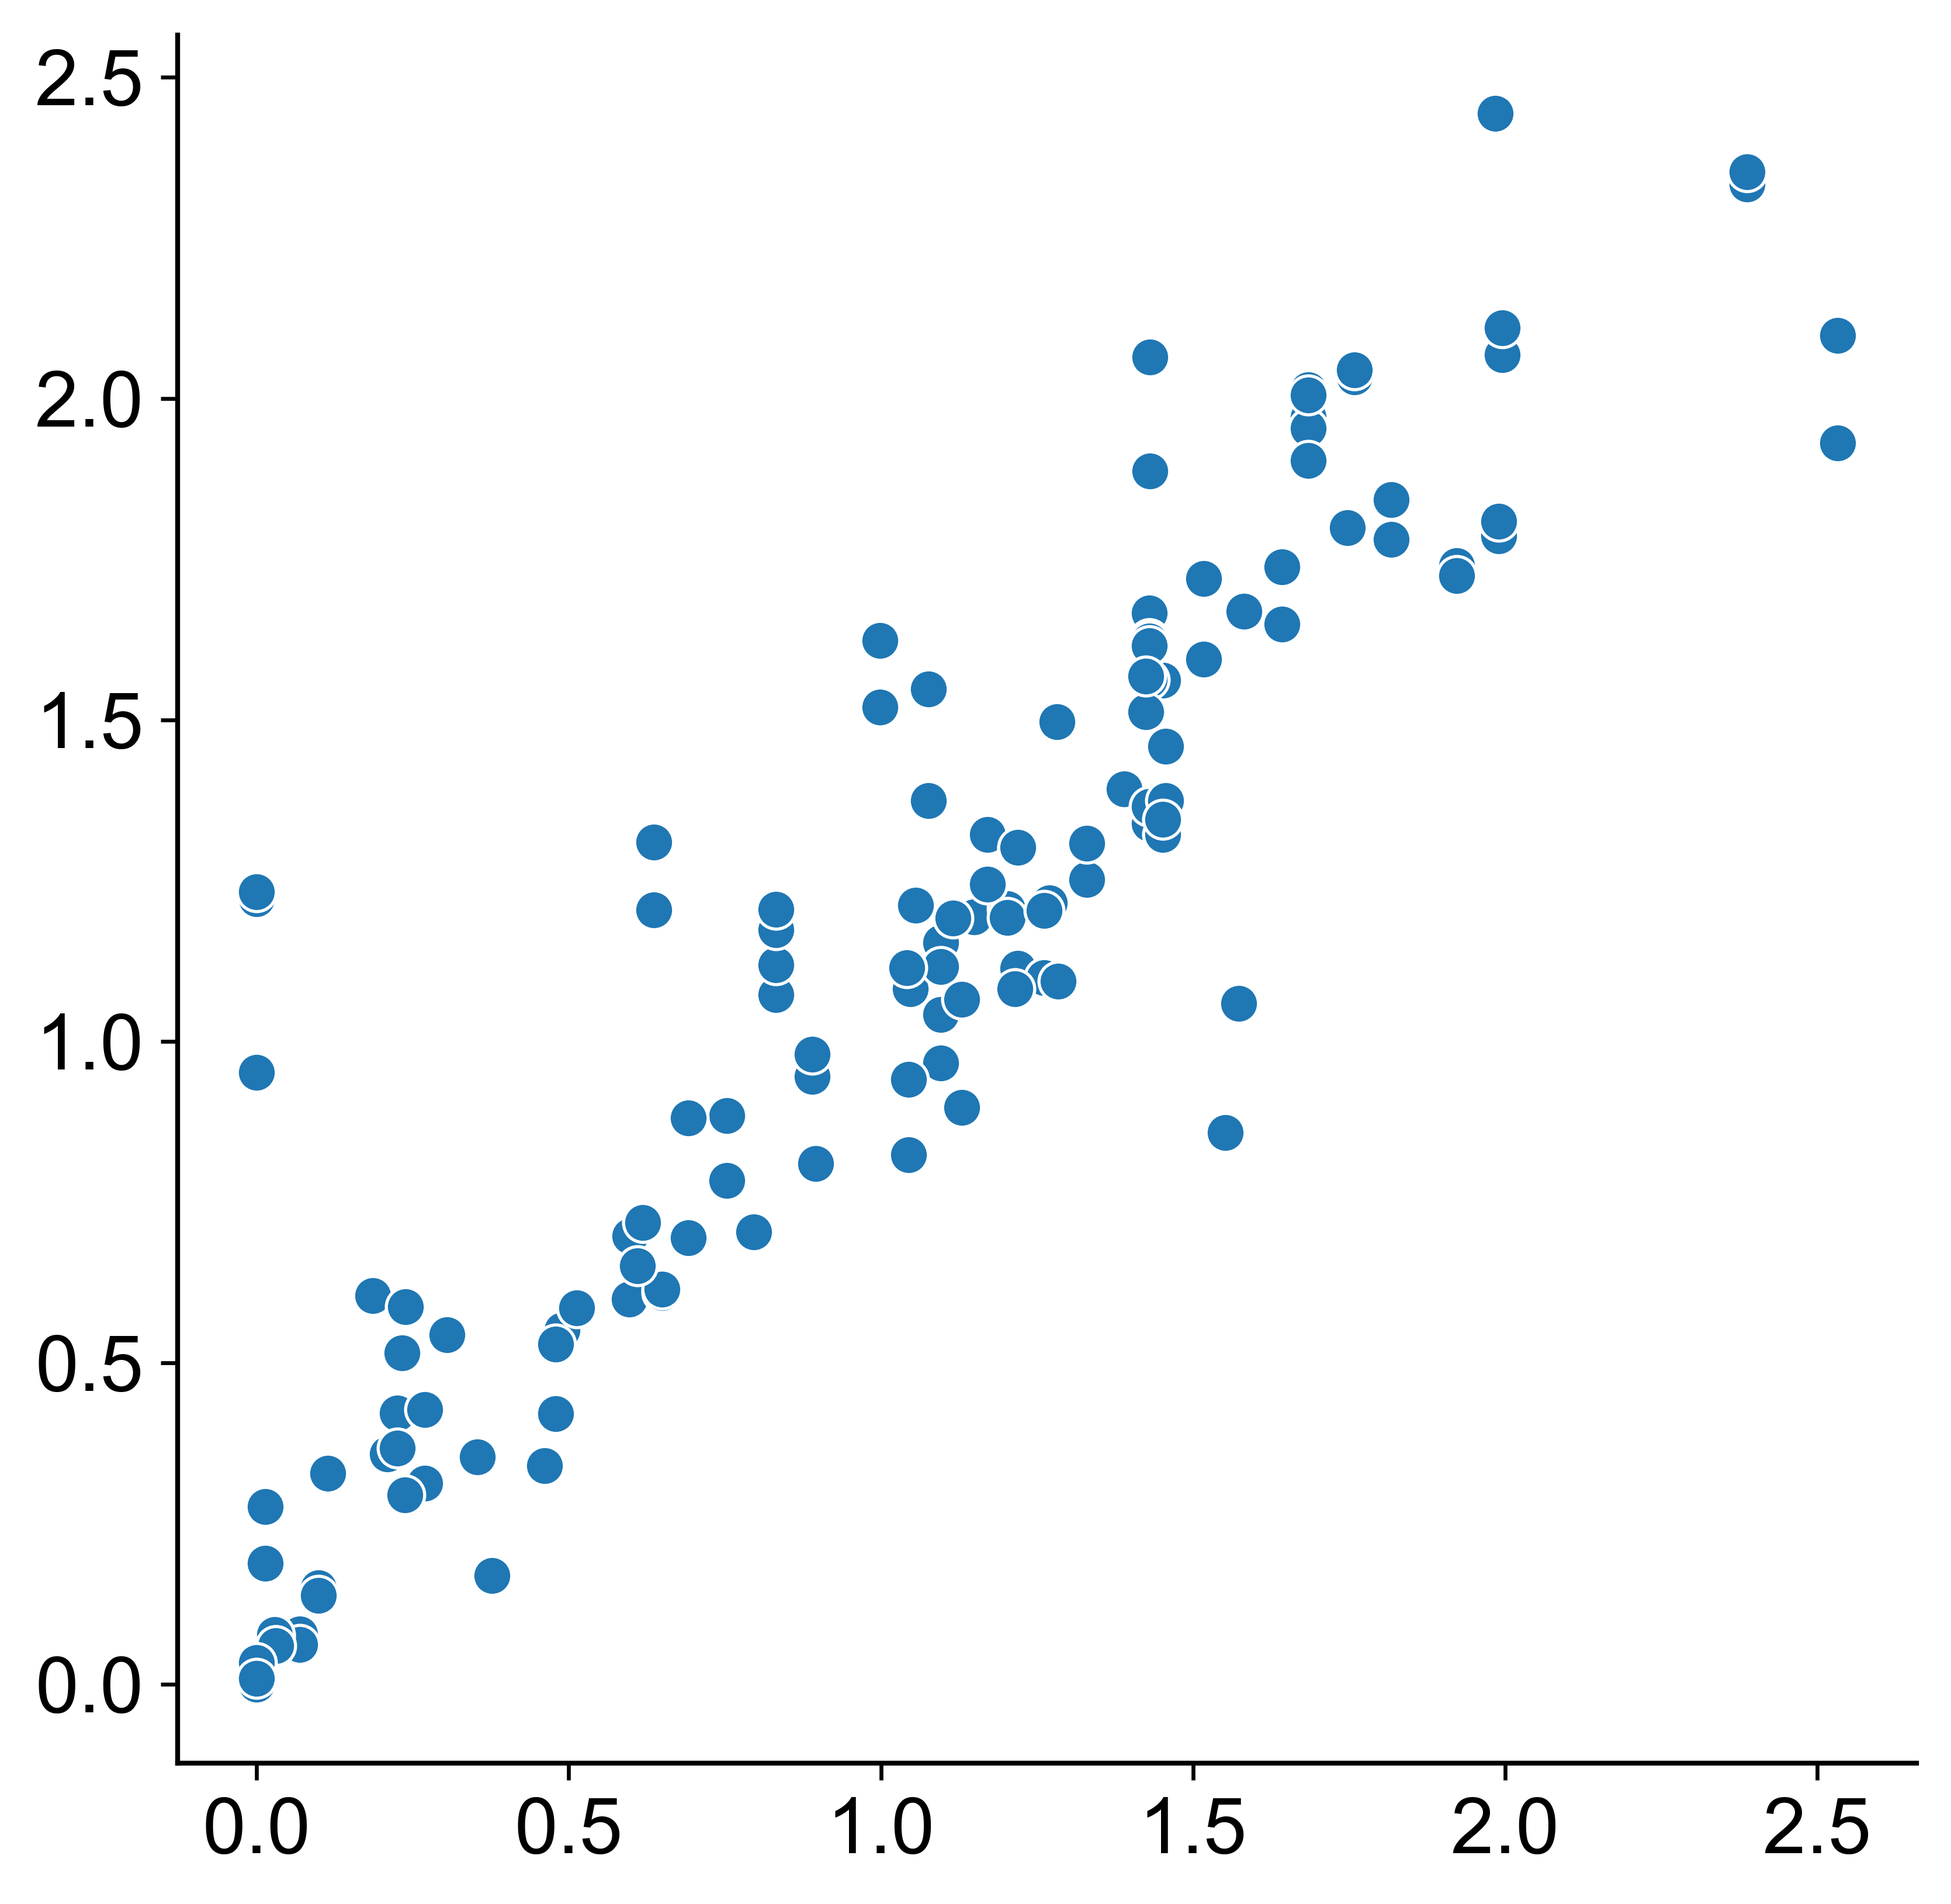

In [22]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
cfg.machine.batch_size=8
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)

In [6]:
cfg.stage='predict'
cfg.dataset.leave_out_chromosomes=''
cfg.task.gene_list = None
cfg.task.test_mode = 'interpret'
cfg.task.layer_names = ['region_embed', 'encoder.blocks.0', 'encoder.blocks.1', 'encoder.blocks.2', 'encoder.blocks.3', 'encoder.blocks.4', 
                        'encoder.blocks.5', 'encoder.blocks.6', 'encoder.blocks.7', 'encoder.blocks.8', 'encoder.blocks.9', 'encoder.blocks.10',
                        'encoder.blocks.11', 'encoder.norm']
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/get_model/utils.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


wandb: Currently logged in as: xf2217 (get-v3). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr4_GL000008v2_random', 'chr5', 'chr6', 'chr7', 'chr7_KI270803v1_alt', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr22_KI270879v1_alt', 'chrX']


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/astrocyte/astrocyte/astrocyte.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])


/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/zarr/storage.py:455: UserWarning: an object_codec is only needed for object arrays
  _init_array_metadata(


Saving batch of results to /home/xf2217/output/astrocyte/astrocyte/astrocyte.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
Saving batch of results to /home/xf2217/output/astrocyte/astrocyte/astrocyte.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
Saving batch of results to /home/xf2217/output/astrocyte/astrocyte/astrocyte.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'fo

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/get_model/utils.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr4_GL000008v2_random', 'chr5', 'chr6', 'chr7', 'chr7_KI270803v1_alt', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr22_KI270879v1_alt', 'chrX']


100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


NameError: name 'exit' is not defined

In [20]:
import zarr
z = zarr.open('/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/tutorials/astrocyte.zarr')


In [27]:
sum((z['expression_positive/astrocyte'][:]+z['expression_negative/astrocyte'][:])>0)

21153

In [ ]:
# umap
import umap
umap_result = umap.UMAP(n_components=2).fit_transform(
    z['embeddings/encoder.blocks.8'][:]
    )
# plot the umap


/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7fdedb487880>
Traceback (most recent call last):
  File "/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


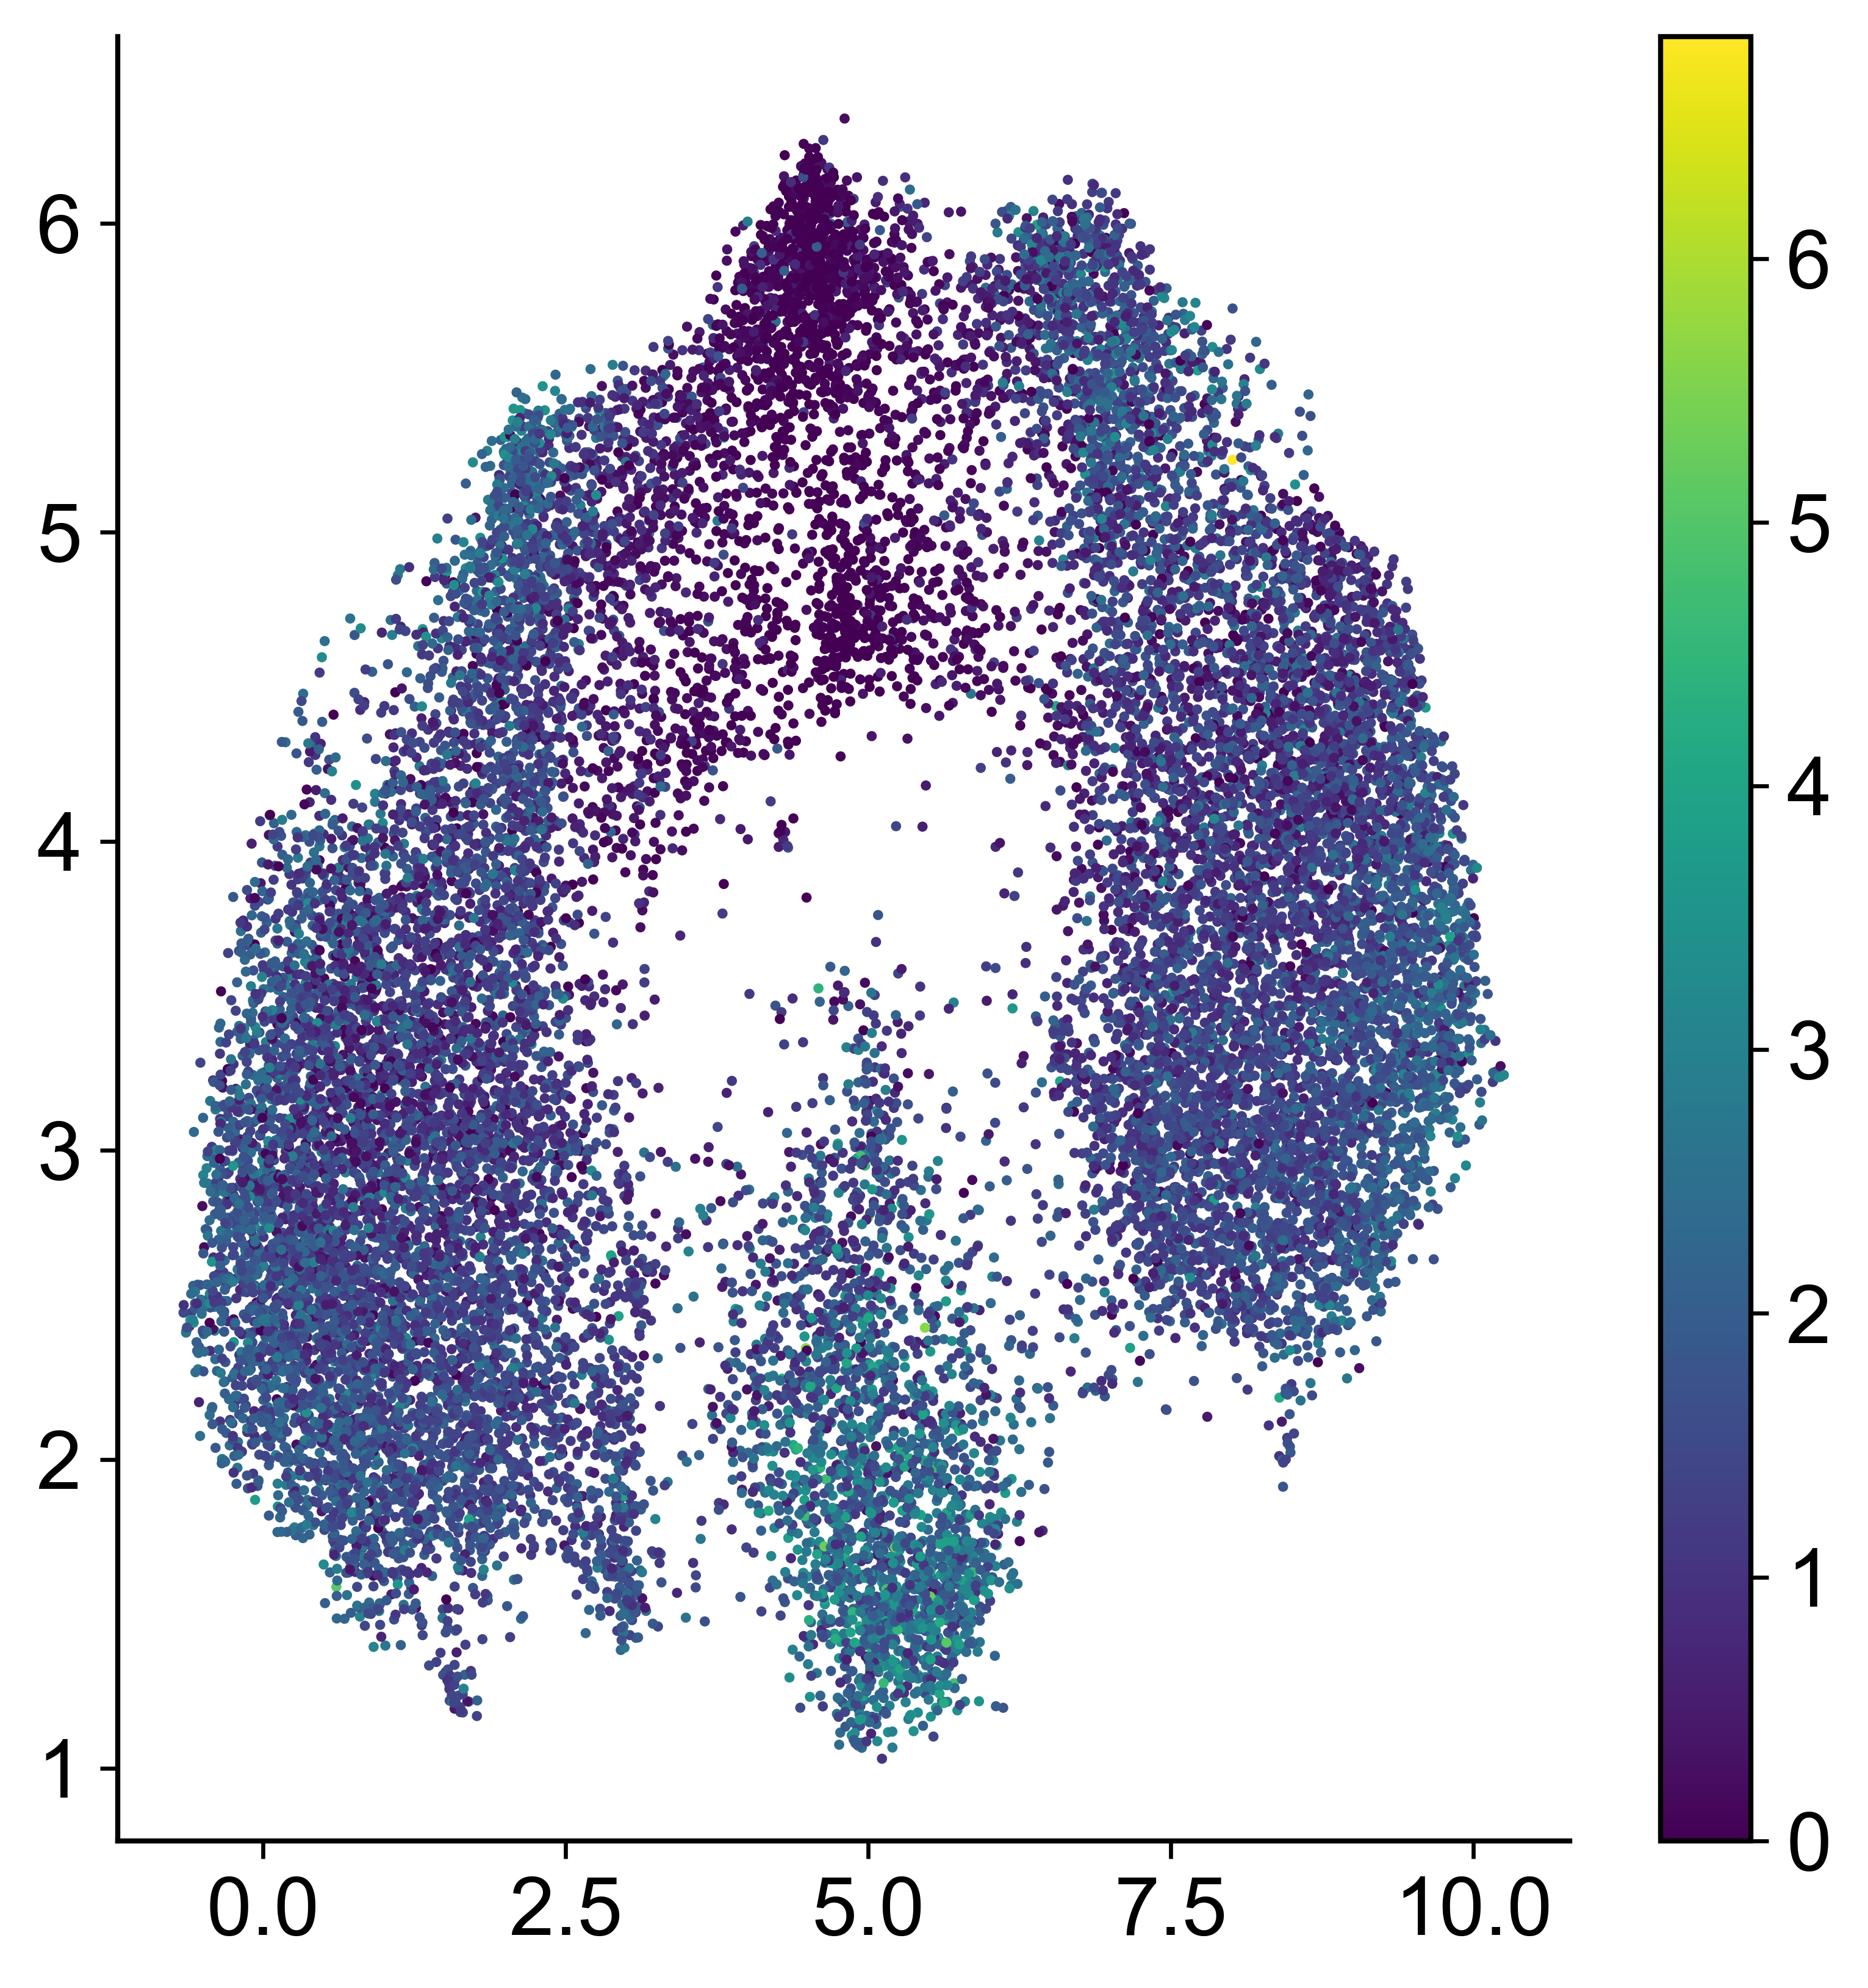

In [22]:
import matplotlib.pyplot as plt
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=z['obs/exp'][:][:,100,:].sum(-1), cmap='viridis', s=1)
plt.colorbar()
plt.show()
